clean data, null values, feature engineering for contributions

In [44]:
import pandas as pd
jim_jordan = pd.read_csv('jim_jordan.csv')
kevin = pd.read_csv('bad_kevin.csv')
sunrise2 = jim_jordan[['committee_id','committee_name', 'entity_type', 'report_year','report_type','contributor_name','contributor_first_name','contributor_last_name','contributor_city','contributor_state','contributor_zip','contributor_employer','contributor_occupation','contribution_receipt_date','contribution_receipt_amount','contributor_aggregate_ytd','election_type','fec_election_type_desc','two_year_transaction_period']]
justice1 = kevin[['committee_id','committee_name', 'entity_type', 'report_year','report_type','contributor_name','contributor_first_name','contributor_last_name','contributor_city','contributor_state','contributor_zip','contributor_employer','contributor_occupation','contribution_receipt_date','contribution_receipt_amount','contributor_aggregate_ytd','election_type','fec_election_type_desc','two_year_transaction_period']]
sunrise1.nunique()
sunrise1 = sunrise2.append(justice1)
sunrise1 = sunrise1.reset_index(drop=True)
sunrise1['election_type'].unique()



/Users/schuylerkarr/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12,32,67,68,72) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/schuylerkarr/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (11,28,38,39,40,44,45,46,47,56,72) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


array(['P2022', 'G2020', 'G2022', 'P2020'], dtype=object)

In [45]:
#Clean NaNs
sunrise1['election_type'] = sunrise1['election_type'].fillna('P')
sunrise1['fec_election_type_desc'] = sunrise1['fec_election_type_desc'].fillna('PRIMARY')
sunrise1 = sunrise1[sunrise1['entity_type'] == 'IND']
sunrise1 = sunrise1[sunrise1['contributor_city'].isna() == False]
sunrise1 = sunrise1[sunrise1['contributor_state'].isna() == False]
sunrise1['contributor_occupation'] = sunrise1['contributor_occupation'].fillna('Anonymous')
sunrise1[sunrise1['contributor_employer'].isna() == True].groupby(by='contributor_occupation').count()
sunrise1['contributor_employer'] = sunrise1['contributor_employer'].fillna(sunrise1['contributor_occupation'])
sunrise1.isna().sum()

#Engineer total and unique contributions and add to df
a = sunrise1.groupby(by='contributor_name').sum().sort_values(by = 'contributor_name', ascending=True)
total_contribution = a['contribution_receipt_amount'].tolist()
b = sunrise1.groupby(by='contributor_name').count().sort_values(by = 'contributor_name', ascending=True)
unique_contributions = b['committee_id'].tolist()
c = sunrise1.groupby(by='contributor_name').mean().sort_values(by = 'contributor_name', ascending=True)
average_contribution1 = c['contribution_receipt_amount'].tolist()
average_contribution = [round(num, 2) for num in average_contribution1]
sunrise1.sort_values(by = 'contributor_name', ascending=True)
sunrise1 = sunrise1.drop_duplicates(subset=['contributor_name'])
sunrise1.shape
sunrise1 = sunrise1.sort_values(by = 'contributor_name', ascending=True)
sunrise1['total_contribution'] = total_contribution
sunrise1['unique_contributions'] = unique_contributions
sunrise1['average_contribution'] = average_contribution
#add climate donor identifier
sunrise1['climate_donor'] = 0
sunrise1 = sunrise1.drop(['contribution_receipt_amount', 'contributor_aggregate_ytd'], axis=1)

Gender

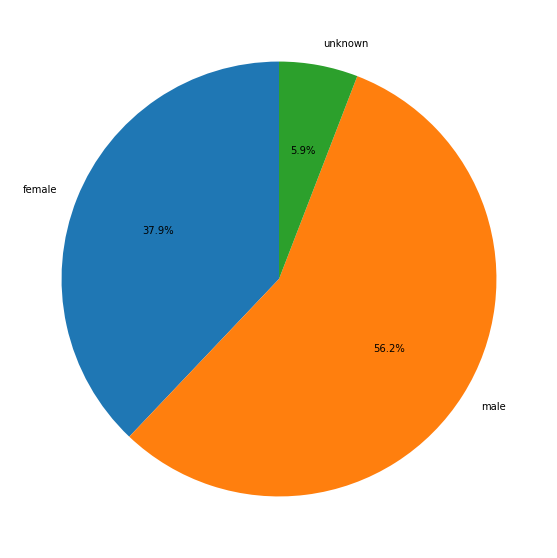

In [46]:
#Engineer gender
import gender_guesser.detector as gender
g = gender.Detector()

first = sunrise1['contributor_first_name'].tolist()
name = []
for x in first:
    a = x.lower()
    b = a.capitalize()
    c = b.split(' ')[0]
    d= g.get_gender(c)
    name.append(d)
name
name1 = []
for x in name:
    if x == 'male':
        name1.append(x)
    elif x == 'mostly_male':
        name1.append('male')
    elif x == 'mostly_female':
        name1.append('female')
    elif x == 'female':
        name1.append(x)
    else:
        name1.append('unknown')
name1
sunrise1['gender'] = name1
sunrise1

%matplotlib inline
import matplotlib.pyplot as plt

genders = sunrise1.groupby(by='gender').count()

labels = genders.index
plt.figure(figsize =(10,10))
plt.pie(genders['committee_id'], labels=labels, startangle=90, autopct='%.1f%%')
plt.show()
sunrise1
sunrise1 = sunrise1[sunrise1['gender']!= 'unknown']

feature engineering: race/ethnicity, with comparison of two algorithms

/Users/schuylerkarr/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


922/922 - 4s


/Users/schuylerkarr/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


922/922 - 4s


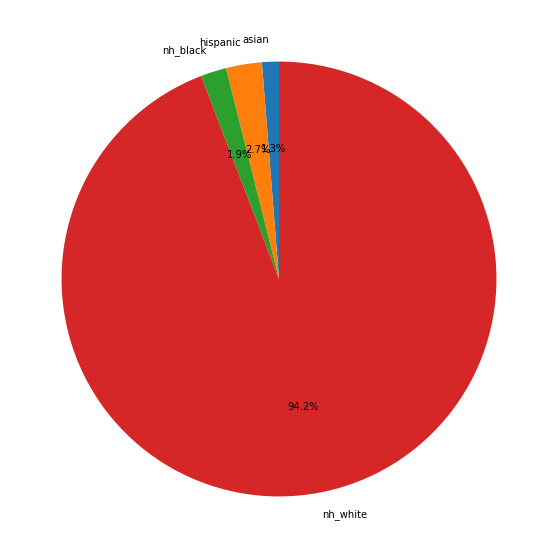

922/922 - 3s
922/922 - 3s


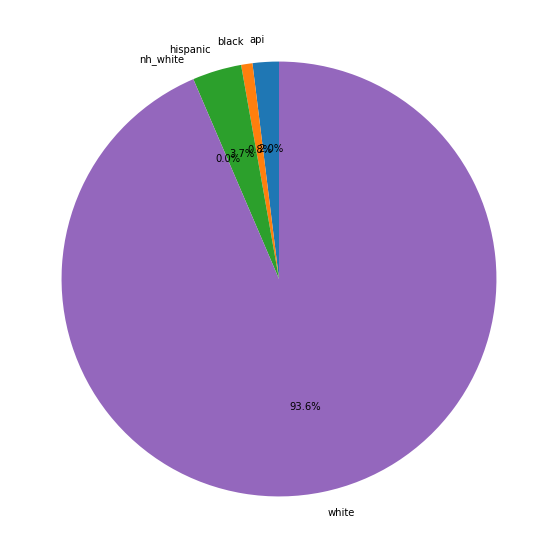

In [47]:
from ethnicolr import pred_fl_reg_name, pred_fl_reg_ln, pred_census_ln

races = pred_fl_reg_name(sunrise1, 'contributor_last_name', 'contributor_first_name')
race = races['race'].tolist()
sunrise1['race'] = race

races = sunrise1.groupby(by='race').count()

labels = races.index
plt.figure(figsize =(10,10))
plt.pie(races['committee_id'], labels=labels, startangle=90, autopct='%.1f%%')
plt.show()

races1 = pred_census_ln(sunrise1, 'contributor_last_name', 2010)
race1 = races1['race'].tolist()
sunrise1['race_census_2010'] = race1

races = sunrise1.groupby(by='race_census_2010').count()

labels = races.index
plt.figure(figsize =(10,10))
plt.pie(races['committee_id'], labels=labels, startangle=90, autopct='%.1f%%')
plt.show()

simplify location from zips to congressional district

In [51]:
sunrise1.nunique()
cd = pd.read_csv('hud_cd_zip.csv')
code = cd['state_abbr'].tolist()
dist = cd['cd'].tolist()
district = [i +'-'+ str(j) for i, j in zip(code, dist)] 
cd['district'] = district
zips = cd[['district', 'zip']]
zips
szip = sunrise1['contributor_zip'].tolist()
szip1 = []
for x in szip:
    y = str(x)[:5]
    z = (y)
    szip1.append(z)
sunrise1['zip'] = szip1
zips
district = []
for x in szip1:
    try:
        df = zips['district'][zips['zip']== int(x)]
        a = df.tolist()
        district.append(a[0])
    except:
        district.append('no_district')
sunrise1['district'] = district
sunrise1[sunrise1['district']== 'no_district']
sunrise1.nunique()
sunrise1 = sunrise1[sunrise1['district']!= 'no_district']

add rural+urban population density 

In [52]:
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)
sunrise1['zip'] = szip1


density = []
for x in szip1:
    zipcode = search.by_zipcode(str(x))
    a = zipcode.to_dict()
    b = [v for (k,v) in a.items() if k == 'population_density']
    for x in b:
        try:
            if int(x) > 2000:
                density.append('urban')
            else:
                density.append('rural')
        except:
            density.append('unknown')
density
sunrise1['urban_rural'] = density
sunrise1[sunrise1['urban_rural']== 'unknown']

sunrise1 = sunrise1[sunrise1['urban_rural']!= 'unknown']



add contribution date as contribution_month

In [53]:
dates = sunrise1[['contribution_receipt_date']]['contribution_receipt_date'].tolist()
months = []
for x in dates:
    a = x[5:7]
    if int(a) == 1:
        b = 'Jan'
        months.append(b)
    if int(a) == 2:
        b = 'Feb'
        months.append(b)

    if int(a) == 3:
        b = 'Mar'
        months.append(b)

    if int(a) == 4:
        b = 'Apr'
        months.append(b)

    if int(a) == 5:
        b = 'May'
        months.append(b)

    if int(a) == 6:
        b = 'Jun'
        months.append(b)

    if int(a) == 7:
        b = 'Jul'
        months.append(b)

    if int(a) == 8:
        b = 'Aug'
        months.append(b)

    if int(a) == 9:
        b = 'Sep'
        months.append(b)

    if int(a) == 10:
        b = 'Oct'
        months.append(b)

    if int(a) == 11:
        b = 'Nov'
        months.append(b)

    if int(a) == 12:
        b = 'Dec'
        months.append(b)
sunrise1['last_donation_month'] = months
#sunrise1[['donation_month','contribution_receipt_date', 'contributor_name']].head(20)
#sunrise[['contributor_name', 'contribution_receipt_date']].sort_values(by = 'contributor_name', ascending=True).head(20)
#list returns latest donation date, but to analyze donation patterns over time, we would need to extract each donation date as a separate column to include in a row

sunrise1



,committee_id,committee_name,entity_type,report_year,report_type,contributor_name,contributor_first_name,contributor_last_name,contributor_city,contributor_state,...,unique_contributions,average_contribution,climate_donor,gender,race,race_census_2010,zip,district,urban_rural,last_donation_month
80959,C00420935,KEVIN MCCARTHY FOR CONGRESS,IND,2020,30G,"(TOWNSEND) MOORE, GWEN",GWEN,(TOWNSEND) MOORE,SUN CITY,AZ,...,2,0.00,0,female,white,white,85351,AZ-8,urban,Oct
24385,C00416594,JIM JORDAN FOR CONGRESS,IND,2020,Q3,".PIERCE, JANICE D",JANICE D,.PIERCE,MOUNTAIN HOME,AR,...,2,22.50,0,female,white,white,72653,AR-1,rural,Sep
45271,C00416594,JIM JORDAN FOR CONGRESS,IND,2020,Q2,"0SBORN, ROBERT",ROBERT,0SBORN,ROBINSON,IL,...,1,150.00,0,male,white,white,62454,IL-15,rural,Jun
131643,C00420935,KEVIN MCCARTHY FOR CONGRESS,IND,2020,Q2,"<MANDY, KATHLEEN",KATHLEEN,<MANDY,PARADISE VALLEY,AZ,...,1,250.00,0,female,white,white,85253,AZ-6,rural,Jun
132383,C00420935,KEVIN MCCARTHY FOR CONGRESS,IND,2020,Q2,"A. HEWITT USAF, LORETTA",LORETTA,A. HEWITT USAF,OAK HARBOR,WA,...,1,200.00,0,female,white,white,98277,WA-2,rural,Jun
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39978,C00416594,JIM JORDAN FOR CONGRESS,IND,2020,Q3,"ZWEIG, ARIE",ARIE,ZWEIG,GLENVIEW,IL,...,1,1000.00,0,male,white,white,60025,IL-10,urban,Jul
77932,C00420935,KEVIN MCCARTHY FOR CONGRESS,IND,2020,30G,"ZWEIG, NATE",NATE,ZWEIG,FORT WAYNE,IN,...,6,29.17,0,female,white,white,46825,IN-3,rural,Oct
1019,C00416594,JIM JORDAN FOR CONGRESS,IND,2020,30G,"ZWEIG, NATHANIEL",NATHANIEL,ZWEIG,FORT WAYNE,IN,...,7,30.14,0,male,white,white,46825,IN-3,rural,Nov
1751,C00416594,JIM JORDAN FOR CONGRESS,IND,2020,30G,"ZWOBODA, JEANNINE",JEANNINE,ZWOBODA,CATSKILL,NY,...,3,15.00,0,female,white,white,12414,NY-19,rural,Nov


simplify states to region and census "division"

In [54]:
states = sunrise1['contributor_state'].tolist()
regions = pd.read_csv('us_regions.csv')
regions
region = []
for x in states:
    if x in regions['State Code'].tolist():
        df = regions['Region'][regions['State Code']== x]
        a = df.tolist()
        region = region + a
    else:
        region.append('puerto_rico')
sunrise1['region'] = region
sunrise1[sunrise1['region']== 'puerto_rico']
sunrise1['region'].unique()

division = []
for x in states:
    if x in regions['State Code'].tolist():
        df = regions['Division'][regions['State Code']== x]
        a = df.tolist()
        division = division + a
    else:
        division.append('unknown')
sunrise1['division'] = division
sunrise1[sunrise1['division']== 'unknown']
sunrise1['division'].unique()
sunrise1 = sunrise1[sunrise1['division']!= 'unknown']

convert "cities" to low, medium, high population- *may update later*

In [55]:
pops = pd.read_csv('city_pops.csv')
pops = pops[['City', 'Population']]
city = pops['City'].tolist()
city1 = []
for x in city:
    a = x.lower()
    city1.append(a)
pops['City'] = city1
pops.head(25)
ccity = sunrise1['contributor_city'].tolist()
ccity1 = []
for x in ccity:
    a = x.lower()
    ccity1.append(a)
sunrise1['city'] = ccity1
pop_size = []
for x in ccity1:
    if x in pops['City'].tolist():
        df = pops['Population'][pops['City'] == x]
        a = df.tolist()
        pop_size = pop_size + a
    else:
        pop_size.append('no_city')



<ipython-input-55-418431775f0f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sunrise1['city'] = ccity1


dropping all columns I don't plan to use in my model

In [56]:
sunrise_clean = sunrise1.drop(columns=['report_year', 'contributor_zip', 'contributor_city', 'district', 'contributor_state', 'two_year_transaction_period', 'contribution_receipt_date', 'contributor_first_name', 'contributor_last_name', 'election_type','committee_id', 'entity_type', 'report_type', 'contributor_name', 'zip'])
sunrise_clean[['urban_rural']].groupby(by='urban_rural').size()

sunrise_clean.columns.tolist()
sunrise_clean_columns = sunrise_clean[['committee_name',
 'contributor_employer',
 'contributor_occupation',
 'fec_election_type_desc',
 'total_contribution',
 'unique_contributions',
 'average_contribution',
 'climate_donor',
 'gender',
 'race',
 'race_census_2010',
 'urban_rural',
 'last_donation_month',
 'region',
 'division']]

sunrise_clean_columns.to_csv('climate_enemies.csv')

